In [1]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import *
from Triangle.Data import * 

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import *
from Triangle_BBH.Utils import *
from Triangle_BBH.Fisher import *

# import multiprocessing

# np.random.seed(114514)
# xp.random.seed(114514)

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


has cupy
has cupy
has BBHx waveform


## Data settings 

In [2]:
t_start = 100. * DAY # start time in s
Tobs = 5. * DAY # data length in s 
t_end = t_start + Tobs # end time in s 
dt = 15. # time cadance in s 
fsample = 1. / dt # sampling rate in Hz 
data_frequencies_full = np.fft.rfftfreq(n=int(Tobs/dt), d=dt) # frequecies where waveform will be calculated 
delta_f = 1. / Tobs

data_frequencies_full.shape 

(14401,)

In [3]:
# mask the "null" frequencies, which may cause singularity in the calculation of likelihood 
mask = np.ones_like(data_frequencies_full, dtype=bool)
for i in range(1, 50): 
    mask_idx = np.where(np.abs(data_frequencies_full - i*0.025)<i*5e-4)[0]
    mask[mask_idx] = False 

# remove the frequencies below Taiji sensitive band 
mask_idx = np.where(data_frequencies_full < 1e-5)[0]
mask[mask_idx] = False 

data_frequencies = data_frequencies_full[mask]
data_frequencies_GPU = xp.array(data_frequencies)

valid_idx = np.where(mask == True)[0]

data_frequencies.shape, valid_idx.shape 

((13964,), (13964,))

## Set response model 

In [4]:
# the path of Taiji orbit 
orbit_GPU = Orbit(OrbitDir="../../Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB") # create individial orbit objects for CPU and GPU to avoid the confusion of numpy / cupy orbit data 

# initialize  waveform generator 
WFG_GPU = BBHxWaveformGenerator(mode="primary", use_gpu=True)

# initialize response generator 
FDTDI_GPU = BBHxFDTDIResponseGenerator(orbit_class=orbit_GPU, waveform_generator=WFG_GPU, use_gpu=True)

# response settings 
response_kwargs_GPU = dict(
    modes=[(2,2)], 
    tc_at_constellation=True,
    tmin=t_start / DAY, # start time in day 
    tmax=t_end / DAY, # end time in day  
    TDIGeneration="2nd", # "1st" or "2nd"
    optimal_combination=True, # True for AET, False for XYZ 
    output_by_mode=False, 
    interpolation=True,
    # interpolation=False, 
)

## Source parameter priors 

In [5]:
lgMc_prior = [5.5, 6.5]
q_prior = [0.1, 1]
s1_prior = [-0.9, 0.9]
s2_prior = [-0.9, 0.9]
tc_prior = [t_start/DAY+3., t_end/DAY-1.] 
lam_prior = [0, TWOPI]
sinbeta_prior = [-1., 1.]
intrinsic_param_priors = np.array([
    lgMc_prior, 
    q_prior, 
    s1_prior, 
    s2_prior, 
    tc_prior, 
    lam_prior, 
    sinbeta_prior, 
])

lgdl_prior = [4., 5.]

intrinsic_param_priors

array([[ 5.50000000e+00,  6.50000000e+00],
       [ 1.00000000e-01,  1.00000000e+00],
       [-9.00000000e-01,  9.00000000e-01],
       [-9.00000000e-01,  9.00000000e-01],
       [ 1.03000000e+02,  1.04000000e+02],
       [ 0.00000000e+00,  6.28318531e+00],
       [-1.00000000e+00,  1.00000000e+00]])

## Noise model 

In [6]:
arm_time = np.mean(intrinsic_param_priors[4]) * DAY 
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit_GPU.LTTfunctions()[key](arm_time)

# theoretical PSDs at the given armlengths 
PSDfunc = TDIPSDs()
PSD_channels = np.array([
    PSDfunc.PSD_A2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_E2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_T2_unequal(data_frequencies, arms)
])

# covariance matrix 
CovMat = np.array([
    [PSD_channels[0], np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), PSD_channels[1], np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0]), PSD_channels[2]]
]) / 4. / delta_f # (3, 3, Nf)

# inverse of covmatrix
InvCovMat = np.linalg.inv(np.transpose(CovMat, (2, 0, 1))) # (Nf, 3, 3)
InvCovMat[:, 2, 2] *= 0. # use A, E channels only in the following analysis 

PSD_channels.shape, InvCovMat.shape 

((3, 13964), (13964, 3, 3))

## Data simulation 

In [7]:
# generate source parameter and clean signal 
mbhb_parameters = {
    'chirp_mass': np.power(10., np.random.uniform(lgMc_prior[0], lgMc_prior[1])), 
    'mass_ratio': np.random.uniform(q_prior[0], q_prior[1]), 
    'spin_1z': np.random.uniform(s1_prior[0], s1_prior[1]),
    'spin_2z': np.random.uniform(s2_prior[0], s2_prior[1]),
    'coalescence_time': np.random.uniform(tc_prior[0], tc_prior[1]), 
    'coalescence_phase': np.random.uniform(0, TWOPI),
    'luminosity_distance': np.power(10., np.random.uniform(lgdl_prior[0], lgdl_prior[1])), 
    'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
    'longitude': np.random.uniform(lam_prior[0], lam_prior[1]), # [rad]
    'latitude': np.arcsin(np.random.uniform(sinbeta_prior[0], sinbeta_prior[1])), # [rad]
    'psi': np.random.uniform(0, PI) # [rad]
    }
wf_channels = FDTDI_GPU.Response(mbhb_parameters, data_frequencies_GPU, **response_kwargs_GPU)

# generate frequency-domain noises 
Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
noise_channels = xp.array(Re_tmp + 1.j * Im_tmp) 

# combine signal and noise 
# data_channels = wf_channels + noise_channels 
data_channels = wf_channels

opt_SNR = FrequencyDomainCovarianceSNR(wf_channels.get(), InvCovMat)

print("source parameters:")
for k, v in mbhb_parameters.items():
    print(k, ":", v)
print("optimal SNR:", opt_SNR)

source parameters:
chirp_mass : 489960.7954555787
mass_ratio : 0.7476017716673712
spin_1z : -0.863885672124118
spin_2z : 0.6654356969843899
coalescence_time : 103.39421830422955
coalescence_phase : 1.7346235307751268
luminosity_distance : 19428.698582801186
inclination : 1.317623537466334
longitude : 2.180941328205518
latitude : -0.3492739491104721
psi : 2.224904326351137
optimal SNR: 1388.2147090323542


Text(0, 0.5, 'Frequency-domain data (1/Hz)')

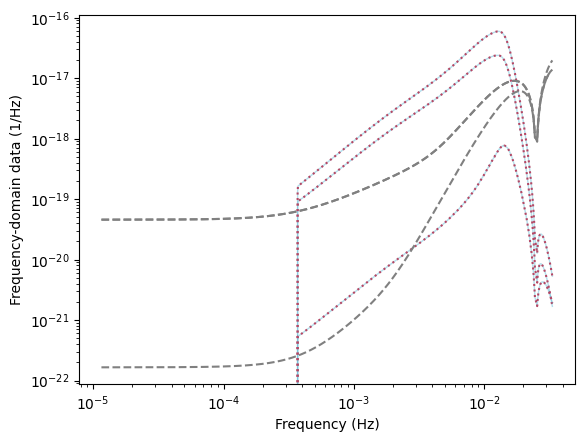

In [8]:
for ichannel, nchannel in enumerate(["A", "E", "T"]): 
    plt.loglog(data_frequencies, np.abs(data_channels[ichannel].get()), linewidth=1, alpha=0.5, color=BLUE)
    plt.loglog(data_frequencies, np.abs(wf_channels[ichannel].get()), color=RED, linestyle=":")
    plt.loglog(data_frequencies, np.sqrt(PSD_channels[ichannel] * Tobs / 2.), color="grey", linestyle="--")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Frequency-domain data (1/Hz)")

## MLE with  $\mathcal{F}$-stat 

In [9]:
Fstat = Fstatistics(
    response_generator=FDTDI_GPU, 
    frequency=data_frequencies_GPU, 
    data=data_channels, 
    # data=wf_channels,
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_GPU, 
    use_gpu=True
)

### test waveform and parameter recovery

In [10]:
int_params = dict()
for key in Fstatistics.intrinsic_parameter_names:
    int_params[key] = mbhb_parameters[key]
int_params

{'chirp_mass': 489960.7954555787,
 'mass_ratio': 0.7476017716673712,
 'spin_1z': -0.863885672124118,
 'spin_2z': 0.6654356969843899,
 'coalescence_time': 103.39421830422955,
 'longitude': 2.180941328205518,
 'latitude': -0.3492739491104721}

In [11]:
rec_a = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=int_params, 
    return_a=True, 
)

rec_ext_params = Fstat.a_to_extrinsic_vectorized(rec_a)

rec_params = dict(int_params, **rec_ext_params)

print("parameter name | difference")
for k, v in rec_ext_params.items():
    print(k, ":", v-mbhb_parameters[k])

parameter name | difference
luminosity_distance : -0.00028109948107157834
inclination : -4.408408971201538e-09
psi : -1.5707963315288942
coalescence_phase : -1.5707963285101492


In [12]:
rec_wave1 = FDTDI_GPU.Response(
    rec_params, 
    data_frequencies_GPU, 
    **response_kwargs_GPU
)

rec_wave2 = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=int_params, 
    return_recovered_wave=True, 
)[:, 0, :]

rec_wave1.shape, rec_wave2.shape 

((3, 13964), (3, 13964))

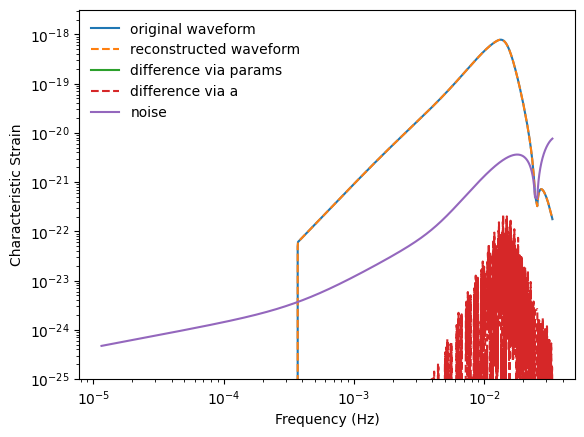

In [13]:
plt.loglog(data_frequencies, np.abs(wf_channels[0].get()) * data_frequencies, label="original waveform")
plt.loglog(data_frequencies, np.abs(rec_wave1[0].get()) * data_frequencies, linestyle="--", label="reconstructed waveform")
plt.loglog(data_frequencies, np.abs(rec_wave1[0].get() - wf_channels[0].get()) * data_frequencies, label="difference via params")
plt.loglog(data_frequencies, np.abs(rec_wave2[0].get() - wf_channels[0].get()) * data_frequencies, label="difference via a", linestyle="--")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies), label="noise")
plt.ylim(1e-25,)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic Strain")
plt.legend(loc="upper left", frameon=False)

In [14]:
int_params_vec = dict() 
for k, v in int_params.items():
    int_params_vec[k] = v * np.ones(10)
f_vec = Fstat.calculate_Fstat_vectorized(intrinsic_parameters=int_params_vec)
f_vec.shape 

(10,)

### optimization from prior 

In [ ]:
from scipy.optimize import differential_evolution

def cost_function(norm_int_params):
    """   
        norm_int_params: shape (Nparams, Nevent), normalized to (0, 1)
    """
    int_params = norm_int_params.transpose() * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0] # (Nevent, Nparams)
    params_in = Fstat.IntParamArr2ParamDict(int_params.transpose()) # (Nparams, Nevent) -> dictionary, each item (Nevent)
    return -Fstat.calculate_Fstat_vectorized(intrinsic_parameters=params_in) # (Nevent)

n_dim_int = 7 
lower_bounds = np.zeros(n_dim_int) 
upper_bounds = np.ones(n_dim_int) 
bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

DE_result = differential_evolution(
    func=cost_function,
    bounds=bounds,
    x0=None,
    strategy='best1exp',
    # strategy='rand1bin',
    maxiter=5000,
    popsize=10*n_dim_int,
    # popsize=6*n_dim_int, 
    tol=1e-8,
    atol=1e-10,
    # tol=1e-7,
    # atol=1e-9,
    # tol=1e-6,
    # atol=1e-8,
    mutation=(0.4, 0.95),
    recombination=0.7,
    disp=False,
    polish=True,
    vectorized=True,
    # workers=1,
)

print(DE_result)

/home/ps/miniconda3/envs/tdc/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'vectorized' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


### reconstruct parameters and waveforms 

In [ ]:
searched_int_params = Fstat.IntParamArr2ParamDict(DE_result.x * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0])

searched_a = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=searched_int_params, 
    return_a=True, 
) # (1, 4)
searched_ext_params = Fstat.a_to_extrinsic_vectorized(searched_a)

searched_params = dict(searched_int_params, **searched_ext_params)

print("parameter name | difference")
for k, v in searched_params.items():
    print(k, np.abs(v-mbhb_parameters[k]))

parameter name | difference
chirp_mass 430.2038501733914
mass_ratio 0.0004985053429162889
spin_1z 0.0061820325430406164
spin_2z 0.054181540990938526
coalescence_time 0.008565453801551826
longitude 1.7579553779745787
latitude 0.2902228624135012
luminosity_distance 5736.153159310445
inclination 0.10200617919098809
psi 1.132922854593139
coalescence_phase 3.129425960969614


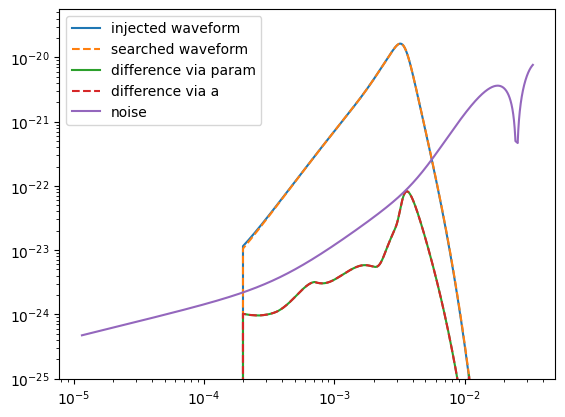

In [ ]:
searched_wf1 = FDTDI_GPU.Response(
    searched_params, 
    data_frequencies_GPU, 
    **response_kwargs_GPU
)

searched_wf2 = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=searched_int_params, 
    return_recovered_wave=True
)[:, 0, :]

plt.loglog(data_frequencies, np.abs(wf_channels[0].get()) * data_frequencies, label="injected waveform")
plt.loglog(data_frequencies, np.abs(searched_wf1[0].get()) * data_frequencies, linestyle="--", label="searched waveform")
plt.loglog(data_frequencies, np.abs(searched_wf1[0].get() - wf_channels[0].get()) * data_frequencies, linestyle="-", label="difference via param")
plt.loglog(data_frequencies, np.abs(searched_wf2[0].get() - wf_channels[0].get()) * data_frequencies, linestyle="--", label="difference via a")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies), label="noise")
plt.ylim(1e-25, )
plt.legend()

## Fisher analysis 

In [ ]:
def fisher_waveform_wrapper(param_dict, frequencies):
    res = FDTDI_GPU.Response(
        parameters=param_dict, 
        freqs=xp.array(frequencies),  
        **response_kwargs_GPU, 
    )
    return res.get()

# set initial steps 
analyze_param_step_dict = {
    'chirp_mass': 10.,
    'mass_ratio': 0.01,
    'spin_1z': 0.01,
    'spin_2z': 0.01,
    'coalescence_time': 0.001,
    'coalescence_phase': 0.1,
    'luminosity_distance': 1.,
    'inclination': 0.01,
    'longitude': 0.01,
    'latitude': 0.01,
    'psi': 0.01
    }
for k, v in analyze_param_step_dict.items():
    analyze_param_step_dict[k] = -v 

FIM = MultiChannelFisher(
    waveform_generator=fisher_waveform_wrapper, 
    param_dict=mbhb_parameters, 
    # param_dict=searched_params, 
    analyze_param_step_dict=analyze_param_step_dict, 
    frequency=data_frequencies, 
    inverse_covariance=InvCovMat, 
    verbose=1,
)

FIM.auto_test_step()
FIM.calculate_Fisher()
FIM.calculate_errors() 

FIM.param_errors

11 parameters in total: ['chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'coalescence_phase', 'luminosity_distance', 'inclination', 'longitude', 'latitude', 'psi']
11 analyzed parameters: ['chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'coalescence_phase', 'luminosity_distance', 'inclination', 'longitude', 'latitude', 'psi']
parameters whose steps should be tested: ['chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'coalescence_phase', 'luminosity_distance', 'inclination', 'longitude', 'latitude', 'psi']

 ========= testing parameter chirp_mass ==========
error = 8.352888694980294
shift = 5.0 relative diff = 1.0410852941988775e-06
shift of parameter chirp_mass is 5.0

 ========= testing parameter mass_ratio ==========
error = 0.004569096544601015
shift = 0.005 relative diff = 0.007556035998875412
error = 0.004545305993041078
shift = 0.0025 relative diff = 0.00866255487011431
error = 0.004536553953744304
shift = 0.00125 re

{'chirp_mass': 327.9639576460221,
 'mass_ratio': 0.00028376185706338196,
 'spin_1z': 0.003065740669074805,
 'spin_2z': 0.026932782376350915,
 'coalescence_time': 9.398639808396346e-05,
 'coalescence_phase': 0.007552068024718944,
 'luminosity_distance': 1432.1532662658929,
 'inclination': 0.002162673847091157,
 'longitude': 0.024344706673176165,
 'latitude': 0.1375958484011444,
 'psi': 0.03406252736627197}

In [ ]:
print("parameter name | truth | difference | FIM bound | ratio")
for k, v in searched_params.items():
    print(k, mbhb_parameters[k], np.abs(v-mbhb_parameters[k]), FIM.param_errors[k], np.abs(v-mbhb_parameters[k]) / FIM.param_errors[k])

parameter name | truth | difference | FIM bound | ratio
chirp_mass 1293988.211249817 430.2038501733914 327.9639576460221 1.3117412451697477
mass_ratio 0.12533791523004087 0.0004985053429162889 0.00028376185706338196 1.7567736131813556
spin_1z 0.5159894461287383 0.0061820325430406164 0.003065740669074805 2.016489067519942
spin_2z 0.25376396334116047 0.054181540990938526 0.026932782376350915 2.011732031017863
coalescence_time 103.65866720184148 0.008565453801551826 9.398639808396346e-05 91.13503630493226
longitude 2.283909036649264 1.7579553779745787 0.024344706673176165 72.21099032224342
latitude -0.1365680001694013 0.2902228624135012 0.1375958484011444 2.1092414181523185
luminosity_distance 14329.346860588186 5736.153159310445 1432.1532662658929 4.005264865447351
inclination 1.6178693783763596 0.10200617919098809 0.002162673847091157 47.166695675442966
psi 1.2517248685909481 1.132922854593139 0.03406252736627197 33.260093780208926
coalescence_phase 3.5257757711711557 3.049425960969614 

## Test across population 

In [ ]:
truths_list = [] 
searched_list = [] 
FIM_bound_list = [] 
snr_list = [] 
res_snr_list = []

for test_idx in tqdm(range(100)):

    # generate source parameter and clean signal 
    mbhb_parameters = {
        'chirp_mass': np.power(10., np.random.uniform(lgMc_prior[0], lgMc_prior[1])), 
        'mass_ratio': np.random.uniform(q_prior[0], q_prior[1]), 
        'spin_1z': np.random.uniform(s1_prior[0], s1_prior[1]),
        'spin_2z': np.random.uniform(s2_prior[0], s2_prior[1]),
        'coalescence_time': np.random.uniform(tc_prior[0], tc_prior[1]), 
        'coalescence_phase': np.random.uniform(0, TWOPI),
        'luminosity_distance': np.power(10., np.random.uniform(lgdl_prior[0], lgdl_prior[1])), 
        'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
        'longitude': np.random.uniform(lam_prior[0], lam_prior[1]), # [rad]
        'latitude': np.arcsin(np.random.uniform(sinbeta_prior[0], sinbeta_prior[1])), # [rad]
        'psi': np.random.uniform(0, PI) # [rad]
        }
    wf_channels = FDTDI_GPU.Response(mbhb_parameters, data_frequencies_GPU, **response_kwargs_GPU)

    # generate frequency-domain noises 
    Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
    Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
    noise_channels = xp.array(Re_tmp + 1.j * Im_tmp) 

    # combine signal and noise 
    # data_channels = wf_channels + noise_channels 
    data_channels = wf_channels

    opt_SNR = FrequencyDomainCovarianceSNR(wf_channels.get(), InvCovMat)
    snr_list.append(opt_SNR)

    Fstat = Fstatistics(
        response_generator=FDTDI_GPU, 
        frequency=data_frequencies_GPU, 
        data=data_channels, 
        invserse_covariance_matrix=InvCovMat, 
        response_parameters=response_kwargs_GPU, 
        use_gpu=True
    )

    def cost_function(norm_int_params):
        """   
            norm_int_params: shape (Nparams, Nevent), normalized to (0, 1)
        """
        int_params = norm_int_params.transpose() * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0] # (Nevent, Nparams)
        params_in = Fstat.IntParamArr2ParamDict(int_params.transpose()) # (Nparams, Nevent) -> dictionary, each item (Nevent)
        return -Fstat.calculate_Fstat_vectorized(intrinsic_parameters=params_in) # (Nevent)

    n_dim_int = 7 
    lower_bounds = np.zeros(n_dim_int) 
    upper_bounds = np.ones(n_dim_int) 
    bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

    DE_result = differential_evolution(
        func=cost_function,
        bounds=bounds,
        x0=None,
        strategy='best1exp',
        # strategy='rand1bin',
        maxiter=5000,
        popsize=10*n_dim_int,
        # popsize=6*n_dim_int, 
        tol=1e-8,
        atol=1e-10,
        # tol=1e-6,
        # atol=1e-8,
        mutation=(0.4, 0.95),
        recombination=0.7,
        disp=False,
        polish=True,
        vectorized=True,
    )

    searched_int_params = Fstat.IntParamArr2ParamDict(DE_result.x * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0])

    searched_a = Fstat.calculate_Fstat_vectorized(
        intrinsic_parameters=searched_int_params, 
        return_a=True, 
    ) # (1, 4)
    searched_ext_params = Fstat.a_to_extrinsic_vectorized(searched_a)

    searched_params = dict(searched_int_params, **searched_ext_params)

    searched_wf = Fstat.calculate_Fstat_vectorized(
        intrinsic_parameters=searched_int_params, 
        return_recovered_wave=True, 
    )[:, 0, :]
    res_snr_list.append(FrequencyDomainCovarianceSNR((wf_channels-searched_wf).get(), InvCovMat))

    def fisher_waveform_wrapper(param_dict, frequencies):
        res = FDTDI_GPU.Response(
            parameters=param_dict, 
            freqs=xp.array(frequencies),  
            **response_kwargs_GPU, 
        )
        return res.get()

    # set initial steps 
    analyze_param_step_dict = {
        'chirp_mass': 10.,
        'mass_ratio': 0.01,
        'spin_1z': 0.01,
        'spin_2z': 0.01,
        'coalescence_time': 0.001,
        'coalescence_phase': 0.01,
        'luminosity_distance': 10.,
        'inclination': 0.01,
        'longitude': 0.01,
        'latitude': 0.01,
        'psi': 0.01
        }
    for k, v in analyze_param_step_dict.items():
        analyze_param_step_dict[k] = -v 

    FIM = MultiChannelFisher(
        waveform_generator=fisher_waveform_wrapper, 
        param_dict=mbhb_parameters, 
        # param_dict=searched_params, 
        analyze_param_step_dict=analyze_param_step_dict, 
        frequency=data_frequencies, 
        inverse_covariance=InvCovMat, 
        verbose=0,
    )

    FIM.auto_test_step()
    FIM.calculate_Fisher()
    FIM.calculate_errors() 

    truths_list.append(mbhb_parameters)
    searched_list.append(searched_params)
    FIM_bound_list.append(FIM.param_errors)
    print("optimal snr =", snr_list[test_idx])
    print("residual snr =", res_snr_list[test_idx])
    print("tc deviation =", searched_list[test_idx]["coalescence_time"]-truths_list[test_idx]["coalescence_time"])
    print("tc bound =", FIM_bound_list[test_idx]["coalescence_time"])

In [ ]:
bins = np.logspace(0., 4.5, 30)
plt.hist(snr_list, bins=bins, density=False, facecolor=None, edgecolor=YELLOW, hatch="//", histtype='step', lw=2); 
plt.hist(res_snr_list, bins=bins, density=False, facecolor=None, edgecolor=BLUE, hatch="//", histtype='step', lw=2); 
plt.xlabel("SNR")
plt.ylabel("number of MBHBs in bin")
plt.xscale("log")

In [ ]:
Mc_list = np.array([paramdict["chirp_mass"] for paramdict in truths_list])
q_list = np.array([paramdict["mass_ratio"] for paramdict in truths_list])
s1_list = np.array([paramdict["spin_1z"] for paramdict in truths_list])
s2_list = np.array([paramdict["spin_2z"] for paramdict in truths_list])
tc_list = np.array([paramdict["coalescence_time"] for paramdict in truths_list])
dl_list = np.array([paramdict["luminosity_distance"] for paramdict in truths_list])
inc_list = np.array([paramdict["inclination"] for paramdict in truths_list])
lon_list = np.array([paramdict["longitude"] for paramdict in truths_list])
lat_list = np.array([paramdict["latitude"] for paramdict in truths_list])

Mc_list1 = np.array([paramdict["chirp_mass"] for paramdict in searched_list])
q_list1 = np.array([paramdict["mass_ratio"] for paramdict in searched_list])
s1_list1 = np.array([paramdict["spin_1z"] for paramdict in searched_list])
s2_list1 = np.array([paramdict["spin_2z"] for paramdict in searched_list])
tc_list1 = np.array([paramdict["coalescence_time"] for paramdict in searched_list])
dl_list1 = np.array([paramdict["luminosity_distance"] for paramdict in searched_list])
inc_list1 = np.array([paramdict["inclination"] for paramdict in searched_list])
lon_list1 = np.array([paramdict["longitude"] for paramdict in searched_list])
lat_list1 = np.array([paramdict["latitude"] for paramdict in searched_list])

Mc_list2 = np.array([paramdict["chirp_mass"] for paramdict in FIM_bound_list])
q_list2 = np.array([paramdict["mass_ratio"] for paramdict in FIM_bound_list])
s1_list2 = np.array([paramdict["spin_1z"] for paramdict in FIM_bound_list])
s2_list2 = np.array([paramdict["spin_2z"] for paramdict in FIM_bound_list])
tc_list2 = np.array([paramdict["coalescence_time"] for paramdict in FIM_bound_list])
dl_list2 = np.array([paramdict["luminosity_distance"] for paramdict in FIM_bound_list])
inc_list2 = np.array([paramdict["inclination"] for paramdict in FIM_bound_list])
lon_list2 = np.array([paramdict["longitude"] for paramdict in FIM_bound_list])
lat_list2 = np.array([paramdict["latitude"] for paramdict in FIM_bound_list])

In [ ]:
bins = np.linspace(-12, 12, 50)
plt.hist((Mc_list1 - Mc_list) / Mc_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="chirp mass");
plt.hist((q_list1 - q_list) / q_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="mass ratio");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

In [ ]:
bins = np.linspace(-12, 12, 50)
plt.hist((s1_list1 - s1_list) / s1_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="spin 1");
plt.hist((s2_list1 - s2_list) / s2_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="spin 2");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

In [ ]:
bins = np.linspace(-100, 100, 50)
plt.hist((lon_list1 - lon_list) / lon_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="longitude");
plt.hist((lat_list1 - lat_list) / lat_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="latitude");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

In [ ]:
bins = np.linspace(-100, 100, 50)
plt.hist((dl_list1 - dl_list) / dl_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="luminosity distance");
plt.hist((inc_list1 - inc_list) / inc_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="inclination");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

In [ ]:
bins = np.linspace(-100, 100, 50)
plt.hist((tc_list1 - tc_list) / tc_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="coalescence time");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

In [ ]:
plt.hist(tc_list - tc_list1);
plt.xlabel("tc error")